# Notebook: pyolimp - Нейросетевые примеры предкомпенсации

### 📦 Импорт библиотек

В этом разделе выполняется импорт необходимых модулей:

- `sys` — для добавления пути к корню проекта;
- `torch` — основная библиотека для работы с тензорами;
- `Tensor` — тип из `torch`, используемый для аннотирования аргументов;
- `Callable` — тип аннотации из `typing`;
- `demo`, `demo_cvd` — утилиты для демонстрации предкомпенсации изображений.

In [1]:
import sys
sys.path.append("../../../")

In [2]:
from typing import Callable
import torch
from torch import Tensor
from olimp.precompensation._demo import demo
from olimp.precompensation._demo_cvd import demo as demo_cvd

### 🧠 Метод DWDN (Deep Wiener Deconvolution Network)

Метод **DWDN** — нейросетевой алгоритм предкомпенсации,  
построенный на архитектуре **глубокой деконволюционной сети**,  
которая приближает работу **фильтра Винера** в обучаемом виде.  
DWDN учитывает как искажения от аберраций зрения (через PSF),  
так и особенности входного изображения, обеспечивая более высокое качество восстановления.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение, нормализованное в диапазоне [0, 1].

📖 Подробнее:  
Метод основан на статье:  
**An End-to-End Learning Framework for Image Precompensation**,  
arXiv, 2021.  
[Скачать PDF](https://arxiv.org/pdf/2103.09962)

Output()

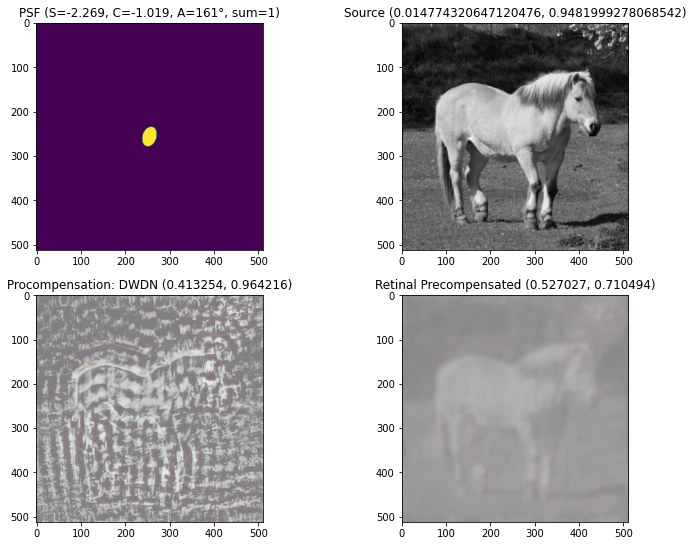

In [3]:
from olimp.precompensation.nn.models.dwdn import PrecompensationDWDN


def demo_dwdn(
    image: Tensor, psf: Tensor, progress: Callable[[float], None]
) -> Tensor:
    model = PrecompensationDWDN.from_path(path="hf://RVI/dwdn.pt")

    with torch.inference_mode():
        inputs = model.preprocess(image, psf.to(torch.float32))
        progress(0.1)
        (precompensation,) = model(inputs, **model.arguments(inputs, psf))
        progress(1.0)
        return precompensation


demo("DWDN", demo_dwdn, mono=True, num_output_channels=3)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.dwdn

### 🧠 Метод USRNet

Метод **USRNet** представляет собой **нейросетевой алгоритм предкомпенсации**,  
основанный на **итеративной деконволюции**. Сеть построена по принципу **развёртывания  
оптимизационного алгоритма**, что позволяет достичь высокой точности восстановления  
деталей изображения при наличии искажений, вызванных аберрациями зрения.

USRNet использует PSF (функцию рассеяния точки) и обучена на синтетических данных,  
включая шум и вариативные уровни искажений, что делает её устойчивой к различным ситуациям.

#### 🧾 Вход:
- изображение;
- PSF (в виде тензора);
- параметры: `scale_factor = 1`, `noise_level = 0`.

#### 📤 Выход:
- предкомпенсированное изображение, восстановленное в RGB и нормализованное.

📖 Подробнее:  
Zhang et al.,  
**Deep Unfolding Network for Image Super-Resolution**,  
CVPR, 2020.  
[Скачать PDF](https://openaccess.thecvf.com/content_CVPR_2020/papers/Zhang_Deep_Unfolding_Network_for_Image_Super-Resolution_CVPR_2020_paper.pdf)

Output()

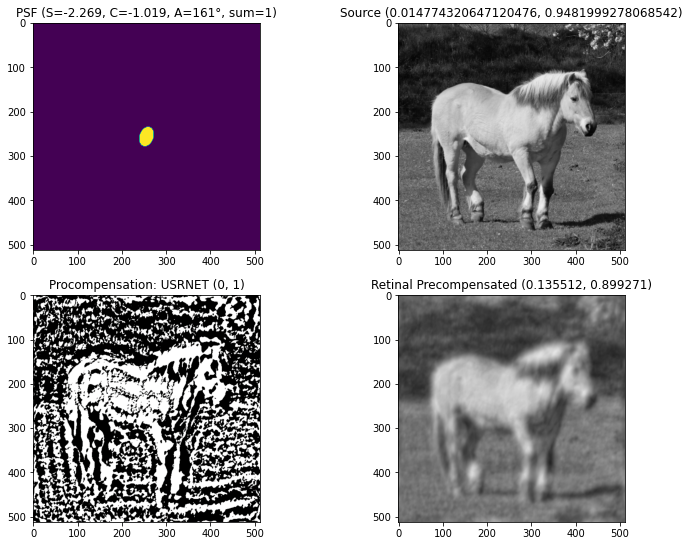

In [4]:
from olimp.precompensation.nn.models.usrnet import PrecompensationUSRNet


def demo_usrnet(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    model = PrecompensationUSRNet.from_path(path="hf://RVI/usrnet.pth")
    with torch.inference_mode():
        psf = psf.to(torch.float32)
        inputs = model.preprocess(image, psf, scale_factor=1, noise_level=0)

        progress(0.1)
        (precompensation,) = model(inputs)
        progress(1.0)
        return precompensation


demo("USRNET", demo_usrnet, mono=True, num_output_channels=3)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.usrnet

### 🧠 Метод CVAE (Conditional Variational Autoencoder)

Метод **CVAE** представляет собой **нейросетевой алгоритм предкомпенсации**,  
основанный на **условном вариационном автокодировщике**. Сеть обучается моделировать  
распределение предкомпенсированных изображений с учётом PSF (функции рассеяния точки),  
что позволяет генерировать реалистичные изображения, устойчивые к различным видам искажений.

CVAE сочетает в себе генеративную модель и стохастический латентный код,  
что делает его пригодным для задач, где необходимо учитывать неопределённость в данных.

#### 🧾 Вход:
- изображение;
- PSF (в виде 2D тензора);
- (внутренне) — кодировка изображения и PSF в латентное пространство  
  и дальнейшая декодировка в предкомпенсированное изображение.

#### 📤 Выход:
- предкомпенсированное изображение;
- среднее (`mu`) и лог-дисперсия (`logvar`) латентного распределения  
  (используются при обучении и для анализа неопределённости).

📖 Подробнее:  
- Zhiwei Xue et. al,  
**Diffusion Models for Probabilistic Deconvolution of Galaxy Images**,   
[Скачать PDF](https://arxiv.org/pdf/2307.11122)  
- Artidoro Pagnoni et al.,  
**Conditional Variational Autoencoder for Neural Machine Translation**,   
[Скачать PDF](https://arxiv.org/abs/1812.04405)


Output()

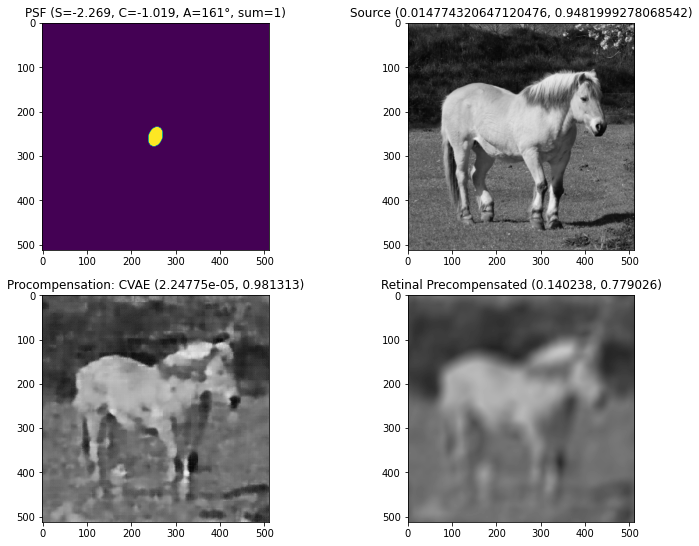

In [5]:
from olimp.precompensation.nn.models.cvae import CVAE


def demo_cvae(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    model = CVAE.from_path("hf://RVI/cvae.pth")
    with torch.inference_mode():
        psf = psf.to(torch.float32)
        inputs = model.preprocess(image, psf)
        progress(0.1)
        (precompensation, mu, logvar) = model(inputs)
        progress(1.0)
        return precompensation


demo("CVAE", demo_cvae, mono=True)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.cvae

### 🧠 Метод VAE (Variational Autoencoder)

Метод **VAE** — это **вариационный автокодировщик**, применённый для задачи предкомпенсации  
зрительных искажений. Он обучается реконструировать предкомпенсированные изображения,  
используя только **изображение и PSF**, без дополнительных условий.

#### 🧾 Вход:
- изображение;
- PSF (в виде 2D тензора);
- модель кодирует вход в латентное представление,  
  которое затем декодируется в предкомпенсацию.

#### 📤 Выход:
- предкомпенсированное изображение;
- параметры латентного распределения (`mu`, `logvar`)  
  (используются при обучении и могут быть применены для анализа неопределённости).

📖 Подробнее:  
- Zhiwei Xue et. al,  
**Diffusion Models for Probabilistic Deconvolution of Galaxy Images**, (Идея взята)  
[Скачать PDF](https://arxiv.org/pdf/2307.11122)  
- Kingma & Welling,  
**Auto-Encoding Variational Bayes**,  
ICLR, 2014.  
[Скачать PDF](https://arxiv.org/pdf/1312.6114) 

Output()

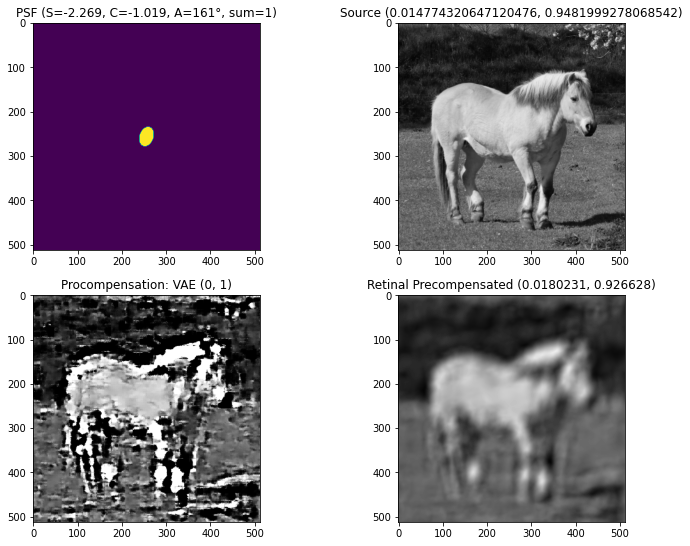

In [6]:
from olimp.precompensation.nn.models.vae import VAE


def demo_vae(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    model = VAE.from_path("hf://RVI/vae.pth")
    with torch.inference_mode():
        psf = psf.to(torch.float32)
        inputs = model.preprocess(image, psf)
        progress(0.1)
        precompensation, _mu, _logvar = model(inputs)
        progress(1.0)
        return precompensation


demo("VAE", demo_vae, mono=True)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.vae

### 🧠 Метод UNET-B0 (на базе EfficientNet)

Метод **UNET-B0** — это модифицированная версия классического U-Net,  
в которой энкодер построен на основе **EfficientNet-B0**.  
Он применяется для задачи предкомпенсации зрительных искажений,  
используя изображение и **PSF** как вход.

#### 🧾 Вход:
- изображение;
- PSF (в виде 2D тензора);
- оба тензора объединяются и подаются на вход сети.

#### 📤 Выход:
- предкомпенсированное изображение  
  (тензор того же размера, что и вход).

📖 Подробнее:  
- Модель построена на основе EfficientNet-B0 (энкодер);  
- Структура декодера соответствует архитектуре U-Net;  
- Модификация для предкомпенсации: *наша реализация без публикации*.  
- Имеет малое количество параметров при высокой точности.

Output()

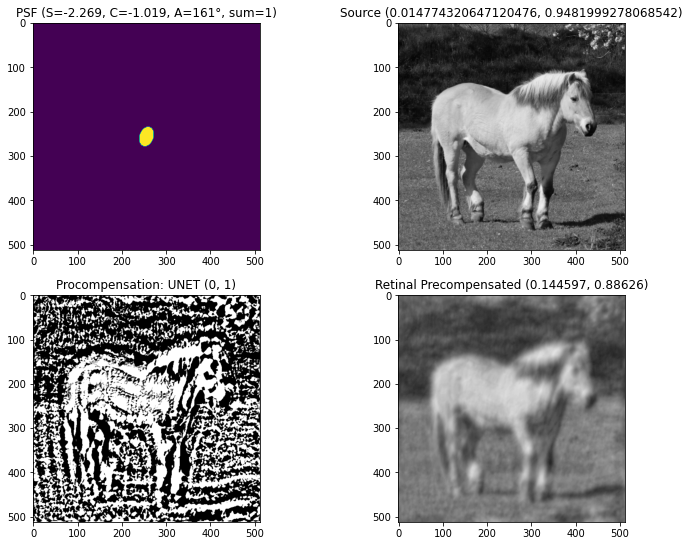

In [7]:
from olimp.precompensation.nn.models.unet_efficient_b0 import (
    PrecompensationUNETB0,
)


def demo_unet(
    image: torch.Tensor,
    psf: torch.Tensor,
    progress: Callable[[float], None],
) -> torch.Tensor:
    model = PrecompensationUNETB0.from_path(
        "hf://RVI/unet-efficientnet-b0.pth"
    )
    with torch.inference_mode():
        psf = psf.to(torch.float32)
        inputs = model.preprocess(image, psf)
        progress(0.1)
        (precompensation,) = model(inputs)
        progress(1.0)
        return precompensation


demo("UNET", demo_unet, mono=True)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.unet_efficient_b0

### 🧠 Метод UNETVAE

Метод **UNETVAE** сочетает в себе преимущества UNet и вариационного автокодировщика (VAE),  
что позволяет моделировать неопределённость и сохранять высокое качество восстановления.  
Модель принимает на вход изображение и **PSF**, извлекает латентное распределение и  
восстанавливает предкомпенсированное изображение.

#### 🧾 Вход:
- изображение;
- PSF (в виде 2D тензора);
- данные кодируются в `mu`, `logvar`, затем реконструируются через выборку из латентного распределения.

#### 📤 Выход:
- предкомпенсированное изображение;
- параметры латентного распределения (`mu`, `logvar`)  
  (используются в процессе обучения и могут быть полезны для анализа).

📖 Подробнее:  
- Архитектура энкодера-декодера построена на основе UNet;  
- Добавлен стохастический латентный слой, как в VAE;  
- Модификация для предкомпенсации: *наша реализация без публикации*.

Output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841858e-07..1.0000002].


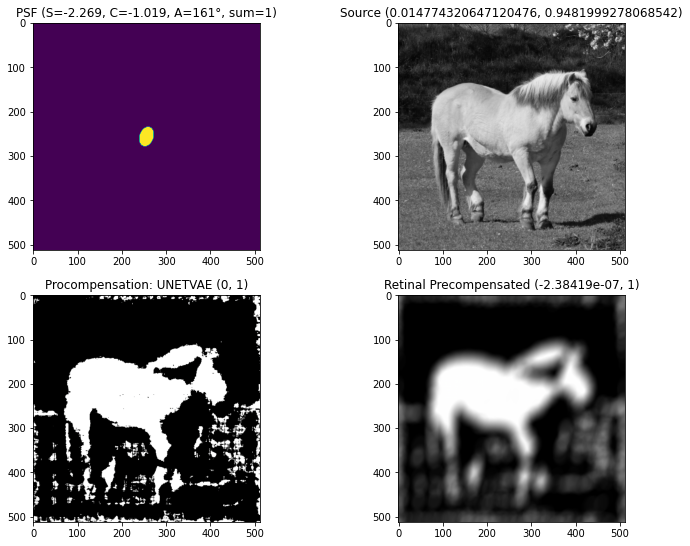

In [8]:
from olimp.precompensation.nn.models.unetvae import UNETVAE


def demo_unetvae(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    model = UNETVAE.from_path("hf://RVI/unetvae.pth")
    with torch.inference_mode():
        psf = psf.to(torch.float32)
        inputs = model.preprocess(image, psf)
        progress(0.1)
        precompensation, _mu, _logvar = model(inputs)
        progress(1.0)
        return precompensation


demo("UNETVAE", demo_unetvae, mono=True)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.unetvae

### 🧠 Метод VDSR (Very Deep Super-Resolution)

Метод **VDSR** — это **глубокая сверточная нейросеть**, адаптированная для задачи  
предкомпенсации зрительных искажений. Исходная архитектура VDSR была разработана для  
сверхразрешения изображений, но в нашей работе она модифицирована для работы с PSF  
(функцией рассеяния точки) и генерации предкомпенсированных изображений.

VDSR использует простую, но эффективную архитектуру с множеством сверточных слоёв,  
что позволяет ей точно восстанавливать детали изображения даже при искажениях.

#### 🧾 Вход:
- изображение;
- PSF (в виде 2D тензора);
- данные обрабатываются и подаются на вход сверточной сети.

#### 📤 Выход:
- предкомпенсированное изображение.

📖 Подробнее:  
- Базовая архитектура:  
  Kim et al.,  
  **Accurate Image Super-Resolution Using Very Deep Convolutional Networks**,  
  CVPR, 2016.  
  [Скачать PDF](https://arxiv.org/pdf/1511.04587)

- Модификация для предкомпенсации: *наша реализация без публикации*.


Output()

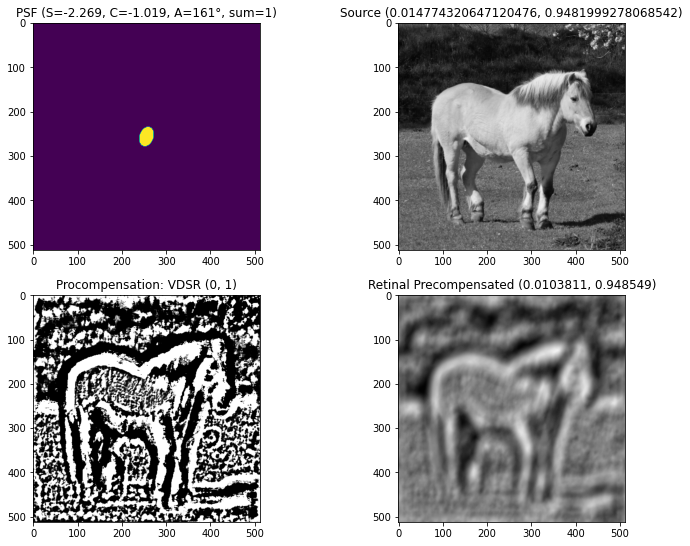

In [9]:
from olimp.precompensation.nn.models.vdsr import VDSR


def demo_vdsr(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    model = VDSR.from_path("hf://RVI/vdsr.pth")
    with torch.inference_mode():
        psf = psf.to(torch.float32)
        inputs = model.preprocess(image, psf)
        progress(0.1)
        (precompensation,) = model(inputs)
        progress(1.0)
        return precompensation


demo("VDSR", demo_vdsr, mono=True)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.vdsr

## 🧠 Метод CVDSwin4Channels

Метод **CVDSwin4Channels** является нашей модификацией, основанной на семействе нейросетей CVD-SWIN (ссылка приведена ниже).
CVD-SWIN представляет собой семейство нейросетевых архитектур, основанных на Swin трансформерах и предназначенных для предкомпенсации цветовых искажений, вызванных дефектами цветового зрения (ДЦЗ).
Используемая функция потерь учитывает как контраст на изображении, так и "натуральность" цветов.
Однако, данная нейросеть ограничена обучением на одном типе искажения: дейтеранопии или протанопии.

Метод **CVDSwin4Channels** включает в себя параметризованный вход, что позволяет обучать нейросеть одновременно на нескольких типах искажений ДЦЗ.
Это реализовано в виде представления параметра искажения (угол между вектором цветовой слепоты и осью L в цветовом пространстве LMS) в виде четвертого канала, 
представляющего собой попиксельное скалярное произведение преобразованного в пространство linRGB изображения и вектора цветовой слепоты в пространстве linRGB.
Дополнительно внесена модификация, по которой нейросеть для предкомпенсации использует преобразования яркости.
Небольшое изменение яркости возникает на этапе квантильного клипинга, где изображение нормализуется в диапазон [0,1] 
частично путем деления всего итогового linRGB изображения на одинаковое число (определяется квантилем от набора 
максимальных значений среди трех каналов по всем пикселям) и частично прямым клиппингом в [0,1].

Это позволяет произвести предкомпенсацию изображения с сохранением исходных цветов.

#### 🧾 Вход:
- изображение (в RGB, затем преобразуется в 4-канальный формат);
- тип дефекта цветового зрения (например, `protan`, `deutan`, или любое другое заданное углом).

#### 📤 Выход:
- предкомпенсированное изображение, пригодное для восприятия пользователем с ДЦЗ.

Метод **CVDSwin4Channels** является нашей модификацией и еще не опубликована.

📖 Подробнее о CVD-SWIN, на которой основана наша модификация:  
Ligeng Chen et al.,  
**Swin Transformer for Precompensation of Refractive and Color Vision Defects**,  
Neural Computing and Applications, Springer, 2023.  
[Скачать PDF](https://link.springer.com/content/pdf/10.1007/s00521-023-09367-2.pdf)

Output()

/home/devel9393/.local/lib/python3.10/site-packages/olimp/evaluation/cs/linrgb.py:35: UserWarning: sRGB range 
should be in [0, 1] not [0.1196029856801033, 1.000000238418579]
  warnings.warn(

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


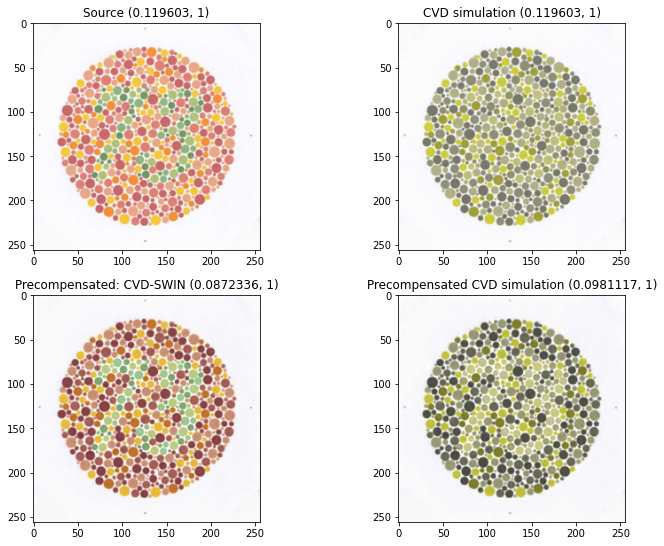

In [10]:
from olimp.precompensation.nn.models.cvd_swin.cvd_swin_4channels import (
    CVDSwin4Channels,
)
from olimp.simulate.color_blindness_distortion import ColorBlindnessDistortion


def demo_cvd_swin(
    image: Tensor,
    distortion: ColorBlindnessDistortion,
    progress: Callable[[float], None],
) -> tuple[torch.Tensor]:
    svd_swin = CVDSwin4Channels.from_path()
    image = svd_swin.preprocess(image, hue_angle_deg=torch.tensor([0.0]))
    progress(0.1)
    precompensation = svd_swin(image)
    progress(1.0)
    return (svd_swin.postprocess(precompensation[0]),)


distortion = ColorBlindnessDistortion.from_type("protan")
demo_cvd(
    "CVD-SWIN",
    demo_cvd_swin,
    distortion=distortion,
)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation_nn.cvd_swin